In [1]:
import sklearn as sk
from sklearn import linear_model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels as stm

In [2]:
X = pd.read_csv('data/preprocessing/X.csv')
y = pd.read_csv('data/preprocessing/y.csv')

In [3]:
X.columns

Index(['educ_center',
       'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
       'harass5_No', 'harass5_Yes', 'polviews_Conservative',
       'polviews_Extremely_liberal', 'polviews_Extrmly_conservative',
       'polviews_Liberal', 'polviews_Moderate',
       'polviews_Slghtly_conservative', 'polviews_Slightly_liberal',
       'advfront_Agree', 'advfront_Disagree', 'advfront_Dont_know',
       'advfront_Strongly_agree', 'advfront_Strongly_disagree', 'snapchat_No',
       'snapchat_Yes', 'instagrm_No', 'instagrm_Yes', 'wrkstat_Keeping_house',
       'wrkstat_Other', 'wrkstat_Retired', 'wrkstat_School',
       'wrkstat_Temp_not_working', 'wrkstat_Unempl,_laid_off',
       'wrkstat_Working_fulltime', 'wrkstat_Working_parttime'],
      dtype='object')

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 28 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   educ_center                                                      1649 non-null   float64
 1   harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)  1649 non-null   int64  
 2   harass5_No                                                       1649 non-null   int64  
 3   harass5_Yes                                                      1649 non-null   int64  
 4   polviews_Conservative                                            1649 non-null   int64  
 5   polviews_Extremely_liberal                                       1649 non-null   int64  
 6   polviews_Extrmly_conservative                                    1649 non-null   int64  
 7   polviews_Liberal                          

In [5]:
sigma = 1e-3

In [6]:
y['noise'] = y['email_time_center'] + sigma

In [7]:
y[y['noise'] == 0]

,email_time_center,noise


array([[<Axes: title={'center': 'email_time_center'}>,
        <Axes: title={'center': 'noise'}>]], dtype=object)

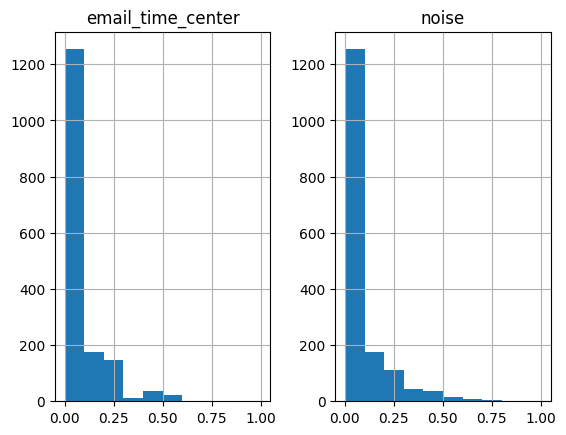

In [8]:
y.hist()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y['noise'], test_size=0.2, random_state=0)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1319, 28)
(330, 28)
(1319,)
(330,)


In [11]:
def print_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  
  print(f'metrics, mse: {mse}, rmse: {rmse}, r2: {r2}')

In [12]:
link_function = stm.genmod.families.links.Log()
gamma_model = stm.api.GLM(y_train, X_train, family=stm.api.families.Gamma(link=link_function))
gamma_results = gamma_model.fit(method='lbfgs')
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1292
Model Family:                   Gamma   Df Model:                           26
Link Function:                    Log   Scale:                          2.7223
Method:                         lbfgs   Log-Likelihood:                 2446.1
Date:                Tue, 15 Aug 2023   Deviance:                       2766.4
Time:                        15:20:40   Pearson chi2:                 3.52e+03
No. Iterations:                    61   Pseudo R-squ. (CS):             0.1155
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
educ_center                                                         1.7504      0.336      5.209      0.000       1.092       2.409
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)     0.5726      1.707      0.335      0.737      -2.774       3.919
harass5_No                                                          1.6409      1.661      0.988      0.323      -1.614       4.896
harass5_Yes                                                         2.1350      1.674      1.276      0.202      -1.145       5.415
polviews_Conservative                                              -0.3099      0.287     -1.080      0.280      -0.872       0.253
polviews_Extremely_liberal                                         -0.3727      0.339     -1.098      0.272      -1.038       0.292
polviews_Extrmly_conservative                                      -0.8873      0.349     -2.544      0.011      -1.571      -0.204
polviews_Liberal                                                   -0.4093      0.292     -1.401      0.161      -0.982       0.163
polviews_Moderate                                                  -0.2547      0.267     -0.954      0.340      -0.778       0.268
polviews_Slghtly_conservative                                      -0.4435      0.286     -1.548      0.122      -1.005       0.118
polviews_Slightly_liberal                                          -0.2259      0.294     -0.770      0.441      -0.801       0.349
advfront_Agree                                                      1.8369      1.661      1.106      0.269      -1.418       5.092
advfront_Disagree                                                   2.0684      1.666      1.241      0.214      -1.197       5.334
advfront_Dont_know                                                  1.3021      1.721      0.757      0.449      -2.070       4.674
advfront_Strongly_agree                                             1.8781      1.662      1.130      0.258      -1.379       5.136
advfront_Strongly_disagree                                          2.8559      1.792      1.594      0.111      -0.657       6.368
snapchat_No                                                        -0.0356        nan        nan        nan         nan         nan
snapchat_Yes                                                        0.2511        nan        nan        nan         nan         nan
instagrm_No                                                         0.1412        nan        nan        nan         nan         nan
instagrm_Yes                                                        0.0743        nan        nan        nan         nan         nan
wrkstat_Keeping_house                          

In [13]:
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1292
Model Family:                   Gamma   Df Model:                           26
Link Function:                    Log   Scale:                          2.7223
Method:                         lbfgs   Log-Likelihood:                 2446.1
Date:                Tue, 15 Aug 2023   Deviance:                       2766.4
Time:                        15:20:40   Pearson chi2:                 3.52e+03
No. Iterations:                    61   Pseudo R-squ. (CS):             0.1155
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
educ_center                                                         1.7504      0.336      5.209      0.000       1.092       2.409
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)     0.5726      1.707      0.335      0.737      -2.774       3.919
harass5_No                                                          1.6409      1.661      0.988      0.323      -1.614       4.896
harass5_Yes                                                         2.1350      1.674      1.276      0.202      -1.145       5.415
polviews_Conservative                                              -0.3099      0.287     -1.080      0.280      -0.872       0.253
polviews_Extremely_liberal                                         -0.3727      0.339     -1.098      0.272      -1.038       0.292
polviews_Extrmly_conservative                                      -0.8873      0.349     -2.544      0.011      -1.571      -0.204
polviews_Liberal                                                   -0.4093      0.292     -1.401      0.161      -0.982       0.163
polviews_Moderate                                                  -0.2547      0.267     -0.954      0.340      -0.778       0.268
polviews_Slghtly_conservative                                      -0.4435      0.286     -1.548      0.122      -1.005       0.118
polviews_Slightly_liberal                                          -0.2259      0.294     -0.770      0.441      -0.801       0.349
advfront_Agree                                                      1.8369      1.661      1.106      0.269      -1.418       5.092
advfront_Disagree                                                   2.0684      1.666      1.241      0.214      -1.197       5.334
advfront_Dont_know                                                  1.3021      1.721      0.757      0.449      -2.070       4.674
advfront_Strongly_agree                                             1.8781      1.662      1.130      0.258      -1.379       5.136
advfront_Strongly_disagree                                          2.8559      1.792      1.594      0.111      -0.657       6.368
snapchat_No                                                        -0.0356        nan        nan        nan         nan         nan
snapchat_Yes                                                        0.2511        nan        nan        nan         nan         nan
instagrm_No                                                         0.1412        nan        nan        nan         nan         nan
instagrm_Yes                                                        0.0743        nan        nan        nan         nan         nan
wrkstat_Keeping_house                          

In [14]:
y_pred = gamma_results.predict(X_test)
print_metrics(y_test, y_pred)

metrics, mse: 0.009016917088084164, rmse: 0.09495744882885263, r2: 0.08934731931459183


In [15]:
choices = ['educ_center', 'wrkstat_Keeping_house', 'wrkstat_Other', 'wrkstat_Retired', 'wrkstat_School', 'wrkstat_Temp_not_working', 'wrkstat_Unempl,_laid_off', 'wrkstat_Working_fulltime', 'wrkstat_Working_parttime']
X_train_choice = X_train[X_train.columns.intersection(choices)]
X_test_choice = X_test[X_test.columns.intersection(choices)]

In [16]:
X_train_choice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 887 to 684
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   educ_center               1319 non-null   float64
 1   wrkstat_Keeping_house     1319 non-null   int64  
 2   wrkstat_Other             1319 non-null   int64  
 3   wrkstat_Retired           1319 non-null   int64  
 4   wrkstat_School            1319 non-null   int64  
 5   wrkstat_Temp_not_working  1319 non-null   int64  
 6   wrkstat_Unempl,_laid_off  1319 non-null   int64  
 7   wrkstat_Working_fulltime  1319 non-null   int64  
 8   wrkstat_Working_parttime  1319 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 103.0 KB


In [17]:
link_function = stm.genmod.families.links.Log()
gm_model = stm.api.GLM(y_train, X_train_choice, family=stm.api.families.Gamma(link=link_function))
gm_res = gm_model.fit(method='lbfgs')
gm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1310
Model Family:                   Gamma   Df Model:                            8
Link Function:                    Log   Scale:                          3.1713
Method:                         lbfgs   Log-Likelihood:                 2367.1
Date:                Tue, 15 Aug 2023   Deviance:                       2861.4
Time:                        15:20:40   Pearson chi2:                 4.15e+03
No. Iterations:                    16   Pseudo R-squ. (CS):            0.07930
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
educ_center                  1.4805      0.331      4.476      0.000       0.832       2.129
wrkstat_Keeping_house       -4.5508      0.267    -17.043      0.000      -5.074      -4.027
wrkstat_Other               -3.9870      0.418     -9.535      0.000      -4.807      -3.167
wrkstat_Retired             -4.2569      0.241    -17.699      0.000      -4.728      -3.786
wrkstat_School              -4.4415      0.356    -12.479      0.000      -5.139      -3.744
wrkstat_Temp_not_working    -3.8865      0.416     -9.342      0.000      -4.702      -3.071
wrkstat_Unempl,_laid_off    -3.7014      0.319    -11.608      0.000      -4.326      -3.076
wrkstat_Working_fulltime    -3.3562      0.241    -13.943      0.000      -3.828      -2.884
wrkstat_Working_parttime    -3.9947      0.258    -15.489      0.000      -4.500      -3.489
============================================================================================
"""

In [18]:
y_pred = gm_res.predict(X_test_choice)

In [19]:
print(y_pred.shape)

(330,)


In [20]:
print_metrics(y_test, y_pred)

metrics, mse: 0.008810617366608623, rmse: 0.09386488889147328, r2: 0.1101823112027418


In [21]:
# link_function = stm.genmod.families.links.Log()
# gm_reg_model = stm.api.GLM(y_train, X_train, family=stm.api.families.Gamma(link=link_function))
# gm_reg_res = gm_reg_model.fit_regularized(method='elastic_net', alpha=0.3, opt_method='bfgs')

In [22]:
# y_pred = gm_reg_res.predict(X_test)
# print_metrics(y_test, y_pred)

In [322]:
x_spline = X_train["educ_center"]
bs = stm.gam.api.BSplines(x_spline, df=8, degree=3)

X_train_wt_educ = X_train[X_train.columns.difference(['educ_center'])]
X_test_wt_educ = X_test[X_test.columns.difference(['educ_center'])]

alpha = 10
gam_bs = stm.gam.api.GLMGam(y_train, X_train_wt_educ, alpha=alpha, smoother=bs, family=sm.families.Gamma(link=sm.families.links.Log()))
fitted_gam = gam_bs.fit()
fitted_gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                         GLMGam   Df Residuals:                  1292.55
Model Family:                   Gamma   Df Model:                        25.45
Link Function:                    Log   Scale:                          2.7201
Method:                         PIRLS   Log-Likelihood:                 2446.5
Date:                Tue, 15 Aug 2023   Deviance:                       2765.8
Time:                        16:06:36   Pearson chi2:                 3.52e+03
No. Iterations:                    42   Pseudo R-squ. (CS):             0.1157
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
advfront_Agree                                                      1.8387      0.972      1.891      0.059      -0.067       3.744
advfront_Disagree                                                   2.0712      0.972      2.131      0.033       0.166       3.976
advfront_Dont_know                                                  1.3040      1.081      1.206      0.228      -0.814       3.422
advfront_Strongly_agree                                             1.8806      0.975      1.929      0.054      -0.030       3.791
advfront_Strongly_disagree                                          2.8598      1.176      2.431      0.015       0.554       5.166
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)     0.5753      1.047      0.550      0.583      -1.476       2.627
harass5_No                                                          1.6428      0.974      1.686      0.092      -0.267       3.553
harass5_Yes                                                         2.1372      1.000      2.138      0.033       0.178       4.097
instagrm_No                                                         0.1417    2.4e+05   5.89e-07      1.000   -4.71e+05    4.71e+05
instagrm_Yes                                                        0.0744    2.4e+05   3.09e-07      1.000   -4.71e+05    4.71e+05
polviews_Conservative                                              -0.3104      0.271     -1.145      0.252      -0.842       0.221
polviews_Extremely_liberal                                         -0.3729      0.327     -1.140      0.254      -1.014       0.268
polviews_Extrmly_conservative                                      -0.8880      0.341     -2.605      0.009      -1.556      -0.220
polviews_Liberal                                                   -0.4095      0.278     -1.472      0.141      -0.955       0.136
polviews_Moderate                                                  -0.2554      0.255     -1.002      0.316      -0.755       0.244
polviews_Slghtly_conservative                                      -0.4443      0.273     -1.628      0.103      -0.979       0.090
polviews_Slightly_liberal                                          -0.2268      0.281     -0.807      0.420      -0.777       0.324
snapchat_No                                                        -0.0357    2.4e+05  -1.49e-07      1.000   -4.71e+05    4.71e+05
snapchat_Yes                                                        0.2516    2.4e+05   1.05e-06      1.000   -4.71e+05    4.71e+05
wrkstat_Keeping_house                                              -6.3757      0.990     -6.439      0.000      -8.316      -4.435
wrkstat_Other                                  

In [323]:
print(X_train.shape)
print(X_test.shape)

(1319, 28)
(330, 28)


In [325]:
y_pred = fitted_gam.predict(exog=X_test_wt_educ, exog_smooth=X_test['educ_center'])
print_metrics(y_test, y_pred)

metrics, mse: 0.00901438641701245, rmse: 0.0949441226038371, r2: 0.08960290139135685


In [326]:
x_spline = X_train["educ_center"]
bs = stm.gam.api.BSplines(x_spline, df=8, degree=3)

X_train_choice_wt_educ = X_train_choice[X_train_choice.columns.difference(['educ_center'])]
X_test_choice_wt_educ = X_test_choice[X_test_choice.columns.difference(['educ_center'])]

alpha = 10
gam_bs = stm.gam.api.GLMGam(y_train, X_train_choice_wt_educ, alpha=alpha, smoother=bs, family=sm.families.Gamma(link=sm.families.links.Log()))
fitted_gam = gam_bs.fit()
fitted_gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                         GLMGam   Df Residuals:                  1310.00
Model Family:                   Gamma   Df Model:                         8.00
Link Function:                    Log   Scale:                          3.1711
Method:                         PIRLS   Log-Likelihood:                 2367.2
Date:                Tue, 15 Aug 2023   Deviance:                       2861.0
Time:                        16:08:20   Pearson chi2:                 4.15e+03
No. Iterations:                    10   Pseudo R-squ. (CS):            0.07938
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
wrkstat_Keeping_house       -4.5498      0.272    -16.710      0.000      -5.083      -4.016
wrkstat_Other               -3.9859      0.426     -9.360      0.000      -4.821      -3.151
wrkstat_Retired             -4.2557      0.262    -16.242      0.000      -4.769      -3.742
wrkstat_School              -4.4407      0.369    -12.033      0.000      -5.164      -3.717
wrkstat_Temp_not_working    -3.8853      0.410     -9.483      0.000      -4.688      -3.082
wrkstat_Unempl,_laid_off    -3.7004      0.333    -11.098      0.000      -4.354      -3.047
wrkstat_Working_fulltime    -3.3554      0.251    -13.373      0.000      -3.847      -2.864
wrkstat_Working_parttime    -3.9938      0.267    -14.933      0.000      -4.518      -3.470
educ_center_s0               0.2728      0.081      3.369      0.001       0.114       0.431
educ_center_s1               0.5708      0.159      3.597      0.000       0.260       0.882
educ_center_s2               0.9321      0.226      4.125      0.000       0.489       1.375
educ_center_s3               1.0424      0.247      4.226      0.000       0.559       1.526
educ_center_s4               1.2334      0.283      4.362      0.000       0.679       1.788
educ_center_s5               1.3680      0.309      4.431      0.000       0.763       1.973
educ_center_s6               1.4759      0.330      4.466      0.000       0.828       2.124
============================================================================================
"""

In [328]:
y_pred = fitted_gam.predict(exog=X_test_choice_wt_educ, exog_smooth=X_test['educ_center'])
print_metrics(y_test, y_pred)

metrics, mse: 0.008808015983073438, rmse: 0.09385103080453319, r2: 0.11044503479958379
